## Training a convnet from scrach on a small dataset

In this tutorial, we will present a few simple yet effective methods that you can use to build a powerful image classifier, using only very few training examples --just a few hundred or thousand pictures from each class you want to be able to recognize.

We will go over the following options:

*   training a small network from scratch (as a baseline)
*   using the bottleneck features of a pre-trained network
*   fine-tuning the top layers of a pre-trained network

This will lead us to cover the following Keras features:

* fit_generator for training Keras a model using Python data generators
* ImageDataGenerator for real-time data augmentation
* layer freezing and model fine-tuning ...and more.

In [1]:
# import libraries
import json
import os, shutil
import cv2
from matplotlib import pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.applications import VGG16

## dataset
the dogs vs cat datset is available by kaggle on part of a competition in late 2013. You can download the original data from [kaggle](www.kaggle.com) or using its api

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# original data directory
data_dir = '/content/train/'
# path for smaller dataset
base_dir = '/content/sample'
os.mkdir(base_dir)
# directories for train, test and validation datasets
train_dir = os.path.join(base_dir,'train')
os.mkdir(train_dir)
test_dir = os.path.join(base_dir,'test')
os.mkdir(test_dir)

In [ ]:

# directories with train, validation and test user1 pictures
train_user1_dir = os.path.join(train_dir,'user1')
test_user1_dir = os.path.join(test_dir,'user1')
os.mkdir(train_user1_dir); os.mkdir(test_user1_dir)


# directories with train, validation and test user4 pictures
train_user4_dir = os.path.join(train_dir,'user4')
test_user4_dir = os.path.join(test_dir,'user4')
os.mkdir(train_user4_dir); os.mkdir(test_user4_dir)

In [ ]:
%cp -r drive/My\ Drive/mouse_dataset/user1/train_images/* /content/sample/train/user1
%cp -r drive/My\ Drive/mouse_dataset/user1/test_images/* /content/sample/test/user1


In [ ]:
%cp -r drive/My\ Drive/mouse_dataset/user4/train_images/* /content/sample/train/user4
%cp -r drive/My\ Drive/mouse_dataset/user4/test_images/* /content/sample/test/user4


In [ ]:

# #copies the first 1000 cat images to train_cats_dir
# fnames = [x for x in os.listdir(data_dir) if 'cat' in x][:1000]
# for fname in fnames:
#   src=os.path.join(data_dir, fname)
#   dst = os.path.join(train_cats_dir, fname)
#   shutil.copyfile(src,dst)

# #copies the first 1000 dog images to train_cats_dir
# fnames = [x for x in os.listdir(data_dir) if 'dog' in x][:1000]
# for fname in fnames:
#   src=os.path.join(data_dir, fname)
#   dst = os.path.join(train_dogs_dir, fname)
#   shutil.copyfile(src,dst)


In [ ]:
# sanity check: count number of images in each folder
print('total training user1 images are: ', len(os.listdir(train_user1_dir)))
print('total test user1 images are: ', len(os.listdir(test_user1_dir)))
print('total training user4 images are: ', len(os.listdir(train_user4_dir)))
print('total validation user4 images are: ', len(os.listdir(test_user4_dir)))


total training user1 images are:  466
total test user1 images are:  88
total training user4 images are:  152
total validation user4 images are:  27


## build the network
the model we will build is based on the convnet model. This model is a stack of alternated conv2D with relu activation and MaxPooling layers

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150,3))) #arbitrary choice for the input shape of images
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), input_shape=(150, 150,3))) #arbitrary choice for the input shape of images
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

## dataPreprocessing

Use keras utilies to preprocess the dataset. The image-preprcessing helper tools is a module locked at **keras.processing.image**. In particular, it contains the class **ImageDataGenerator** which lets you quickly set Python generators that can automatically turn images files on disk into batches of preprocessed tendors.

* read the files(files are still stored in disk)
* decode to RGB grids of pixels
* convert into floating point tensor
* rescame the pixel values(between 0 and 255) to the [0,1] interval

In [ ]:
## using ImageDataGenerator to read images from directories
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size=5
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 618 images belonging to 2 classes.
Found 115 images belonging to 2 classes.


In [ ]:
# take a look at batch generator 
for data_bach, label_batch in train_generator:
  print(data_bach.shape)
  print(label_batch.shape)
  break

(5, 150, 150, 3)
(5,)


In [ ]:
# fit the data
history = model.fit_generator(train_generator, 
                              steps_per_epoch=50, # #samples per generator before declaring epoch ended 
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 34s 657ms/step - loss: 0.4245 - acc: 0.8635 - val_loss: 0.1073 - val_acc: 0.9800
Epoch 2/10
50/50 [==============================] - 32s 644ms/step - loss: 0.1456 - acc: 0.9400 - val_loss: 0.0763 - val_acc: 0.9800
Epoch 3/10
50/50 [==============================] - 33s 651ms/step - loss: 0.0620 - acc: 0.9740 - val_loss: 0.0905 - val_acc: 0.9500
Epoch 4/10
50/50 [==============================] - 32s 645ms/step - loss: 0.0587 - acc: 0.9849 - val_loss: 0.0960 - val_acc: 0.9500
Epoch 5/10
50/50 [==============================] - 33s 650ms/step - loss: 0.1139 - acc: 0.9395 - val_loss: 0.0531 - val_acc: 0.9900
Epoch 6/10
50/50 [==============================] - 33s 651ms/step - loss: 0.0938 - acc: 0.9650 - val_loss: 0.0658 - val_acc: 0.9800
Epoch 7/10
50/50 [==============================] - 32s 647ms/step - loss: 0.0795 - acc: 0.9671 - val_loss: 0.0509 - val_acc: 0.9900
Epoch 8/10
50/50 [==============================] - 32s 643ms/step - 

<function matplotlib.pyplot.show>

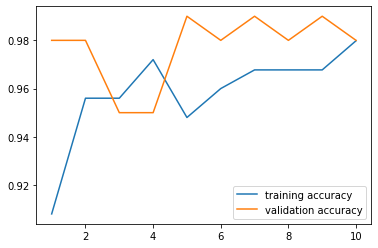

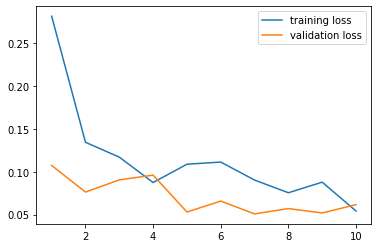

In [ ]:
# display curves of loss and accuracy during training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.show

## build the network
the model we will build is based on the convnet model. This model is a stack of alternated conv2D with relu activation and MaxPooling layers

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150,3))) #arbitrary choice for the input shape of images
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), input_shape=(150, 150,3))) #arbitrary choice for the input shape of images
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_13 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

## dataPreprocessing

Use keras utilies to preprocess the dataset. The image-preprcessing helper tools is a module locked at **keras.processing.image**. In particular, it contains the class **ImageDataGenerator** which lets you quickly set Python generators that can automatically turn images files on disk into batches of preprocessed tendors.

* read the files(files are still stored in disk)
* decode to RGB grids of pixels
* convert into floating point tensor
* rescame the pixel values(between 0 and 255) to the [0,1] interval

In [ ]:
## using ImageDataGenerator to read images from directories
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size=5
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# # this is a similar generator, for validation data
# validation_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(150, 150),
#         batch_size=batch_size,
#         class_mode='binary')

Found 618 images belonging to 2 classes.


In [ ]:
# take a look at batch generator 
for data_bach, label_batch in train_generator:
  print(data_bach.shape)
  print(label_batch.shape)
  break

(5, 150, 150, 3)
(5,)


In [ ]:
# fit the data
history = model.fit_generator(train_generator, 
                              steps_per_epoch=50, # #samples per generator before declaring epoch ended 
                              epochs=10)
#,                              validation_data=validation_generator,
#                              validation_steps=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 25s 485ms/step - loss: 0.4339 - acc: 0.8416
Epoch 2/10
50/50 [==============================] - 24s 482ms/step - loss: 0.0909 - acc: 0.9737
Epoch 3/10
50/50 [==============================] - 24s 479ms/step - loss: 0.1631 - acc: 0.9639
Epoch 4/10
50/50 [==============================] - 24s 482ms/step - loss: 0.0866 - acc: 0.9641
Epoch 5/10
50/50 [==============================] - 25s 484ms/step - loss: 0.0927 - acc: 0.9464
Epoch 6/10
50/50 [==============================] - 24s 480ms/step - loss: 0.1031 - acc: 0.9430
Epoch 7/10
50/50 [==============================] - 24s 481ms/step - loss: 0.1011 - acc: 0.9528
Epoch 8/10
50/50 [==============================] - 24s 479ms/step - loss: 0.0819 - acc: 0.9755
Epoch 9/10
50/50 [==============================] - 24s 483ms/step - loss: 0.0912 - acc: 0.9348
Epoch 10/10
50/50 [==============================] - 25s 485ms/step - loss: 0.0583 - acc: 0.9763


<function matplotlib.pyplot.show>

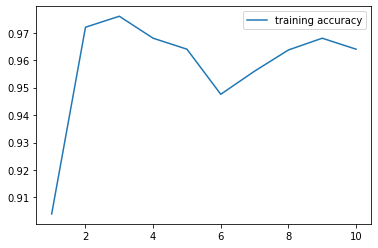

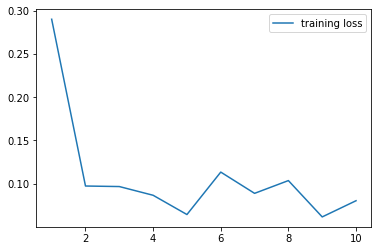

In [ ]:
# display curves of loss and accuracy during training
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, label='training accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.legend()
plt.show

In [ ]:
model.save("/home/ilyes/Desktop/detailed_Keras_MultiLabel_classification/my_model.h5")


# TEST

In [ ]:
# %cp sample/test test_user1
# %rm -rf test_user1/user4 

In [ ]:
pwd

'/content'

In [ ]:
## using ImageDataGenerator to read images from directories
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size=5
# train_generator = train_datagen.flow_from_directory(
#         train_dir,  # this is the target directory
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator_user1 = test_datagen.flow_from_directory(
        "/content/test_user1",
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

Found 88 images belonging to 1 classes.


In [ ]:
#validation_generator[1][0]

In [ ]:
# give a probability for each class
proba = model.predict(validation_generator_user1[85][0])[0]

# take the two higher probas
top_two = np.argsort(proba)[::-1][:2]

In [ ]:
proba

array([2.45774e-06], dtype=float32)

In [ ]:
%cp -r sample/test test_user4
%rm -rf test_user4/user1 

In [ ]:
## using ImageDataGenerator to read images from directories
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size=5
# train_generator = train_datagen.flow_from_directory(
#         train_dir,  # this is the target directory
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator_user4 = test_datagen.flow_from_directory(
        "/content/test_user4",
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

Found 27 images belonging to 1 classes.


In [ ]:
# give a probability for each class
proba = model.predict(validation_generator_user4[9][0])[0]

# take the two higher probas
top_two = np.argsort(proba)[::-1][:2]

In [ ]:
proba

array([0.84331256], dtype=float32)

## Data Augmentation


In [ ]:
# data augmentation configuration via ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2, #shearing transformations
        zoom_range=0.2,
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) #Ok if no assumptions of horizontal asymmetry

In [ ]:
x.reshape(1,x.shape)

TypeError: ignored

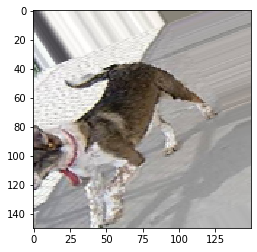

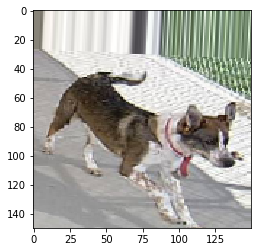

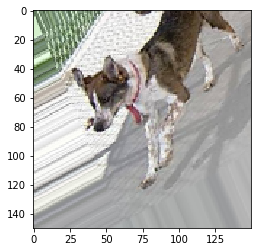

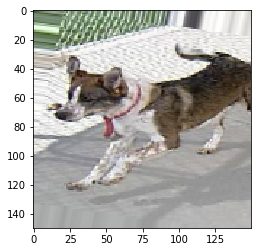

In [ ]:
# displaying some randomly augemented images
fnames = [x for x in os.listdir(data_dir) if 'dog' in x]
img_path = data_dir+fnames[5]
img = load_img(img_path, target_size=(150,150))
# convert it to numpy array with shape(150,150,3)
x = img_to_array(img)
x = x.reshape((1,)+x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

i=0
for batch in datagen.flow(x, batch_size=1): 
  plt.figure(i)
  imgplot = plt.imshow(img_to_array(batch[0]))
  i+=1
  if i%4==0:
    break
plt.show()

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(150, 150,3))) #arbitrary choice for the input shape of images
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), input_shape=(150, 150,3))) #arbitrary choice for the input shape of images
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))


model1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.summary()

model1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.



Epoch 1/30





100/100 [==============================] - 127s 1s/step - loss: 0.6948 - acc: 0.5170 - val_loss: 0.6886 - val_acc: 0.5540
Epoch 2/30
100/100 [==============================] - 123s 1s/step - loss: 0.6874 - acc: 0.5340 - val_loss: 0.6714 - val_acc: 0.5740
Epoch 3/30
100/100 [==============================] - 125s 1s/step - loss: 0.6739 - acc: 0.5785 - val_loss: 0.6742 - val_acc: 0.5540
Epoch 4/30
100/100 [==============================] - 123s 1s/step - loss: 0.6708 - acc: 0.5905 - val_loss: 0.6338 - val_acc: 0.6600
Epoch 5/30
100/100 [==============================] - 124s 1s/step - loss: 0.6523 - acc: 0.6115 - val_loss: 0.7050 - val_acc: 0.5440
Epoch 6/30
100/100 [==============================] - 124s 1s/step - loss: 0.6442 - acc: 0.6245 - val_loss: 0.6240 - val_acc: 0.6590
Epoch 7/30
100/100 [==============================] - 124s 1s/step - loss: 0.6357 - acc: 0.6455 - val_loss: 0.

<function matplotlib.pyplot.show>

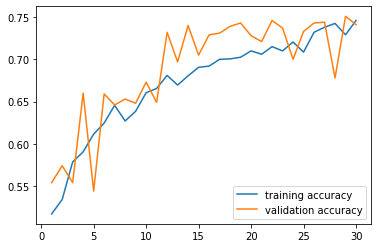

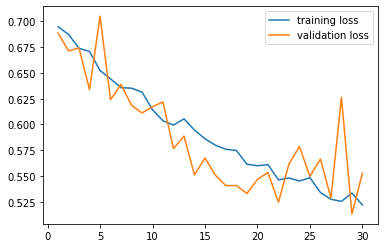

In [ ]:
# training convnet using dataAugmentatin generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

# obviously validation data should't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size=20
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
#fit generator
history = model1.fit_generator(train_generator, 
                              steps_per_epoch=100, # #samples per generator before declaring epoch ended 
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

# display curves of loss and accuracy during training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.show

## using a pretrained convnet

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem.

### feature extraction
- use learned representations by a previous network to extract interesting features
- use these features to run a new classifier

In [ ]:
# instantiate the vgg16 convolutional base from keras
conv_base = VGG16(weights='imagenet', 
                  include_top=False, #include or not the FCC layer 
                  input_shape=(150,150,3))

conv_base.summary()
model3 = Sequential()
model3.add(conv_base)
model3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# freeze the convolutional base
conv_base.trainable=False

In [ ]:
# training convnet using dataAugmentatin generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

# obviously validation data should't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
#fit generator
history = model3.fit_generator(train_generator, 
                              steps_per_epoch=100, # #samples per generator before declaring epoch ended 
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

# display curves of loss and accuracy during training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 1984s 20s/step - loss: 7.8791 - acc: 0.4975 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 1989s 20s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 1974s 20s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/30
100/100 [==============================] - 1968s 20s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/30
100/100 [==============================] - 1972s 20s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/30
100/100 [==============================] - 1962s 20s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/30
100/100 [==============================] - 1976s 20s/step - loss: 7.9712 - acc: 0.5000 - val_lo

## Wrapping-up 
- Convnets are the best tool for attacking visual-classification problems.
- The representations they learn are easy to inspect — convnets the opposite of black boxes!
- You can use  data augmentation to fight overfitting.
- You can use a pretrained convnet to do feature extraction and fine-tuning.
